# GAMMA WW Trainings: Intro to Classification in Python

<b>Topics Covered in this notebook</b>
* Basic EDA and checks on the dataset
* Training and evaluating performance of multiple Classifier algorithms
* Exploring model validation and key performance metrics
* Hyper-parameter tuning using GridSearchCV for the classification algorithms to see improvement in performance
* Ensembling for further improvement in performance
* Whiteboxing your Blackbox model

Authors: Pulkit Gupta, Advait Save

Date: 08-October-2018

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Packages

- Package import section allows us to include packages to be used within the notebook


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve 
from sklearn import metrics
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier
import scikitplot as skplt
import lime 
import lime.lime_tabular
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os

#Add Graphviz path to environment variable PATH, used for visualizing decision trees
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#Import supporting functions
from calculate_model_metrics import lift_plot_model, plot_roc, plot_grid_search, evaluate_model

import warnings
warnings.filterwarnings("ignore")

## Problem Statement
- <b>Objective:</b> To predict whether a customer will Churn based on his/her telecom usage information
- <b>Data:</b> Customer level usage data for a telecommunications company, with historical Churn information

## Basic EDA

#### Reading data

In [3]:
data = pd.read_csv("../data/churn.csv")

#### What does our data look like ?

In [4]:
print(data.shape)
data.head(5)

(3333, 21)


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Analyze data for data integrity check
- The following statistics can be cross-checked with business to see if they make sense

In [5]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
data['Area Code'].unique()

array([415, 408, 510], dtype=object)

In [8]:
data['Area Code']   = data['Area Code'].astype('object')

In [9]:
data.describe(include=['O'])

,State,Area Code,Phone,Int'l Plan,VMail Plan,Churn?
count,3333,3333,3333,3333,3333,3333
unique,51,3,3333,2,2,2
top,WV,415,354-6942,no,no,False.
freq,106,1655,1,3010,2411,2850


In [10]:
print("Churn Rate: {} %".format(round(sum(np.where(data['Churn?'] == 'False.',0,1))*100.0/len(data['Churn?']),2)))

Churn Rate: 14.49 %


#### Define Target Feature and Id features

In [11]:
target_variable = ["Churn?"]
id_variable = ["Phone"]

### Analysing the data using visalization

#### Correlation between the features

Observations:
- We can see that the Day, Night, Evening and International minutes fields are perfectly correlated to the corresponding Charge fields
- The "Charge" fields are removed to avoid multicollinearity while training the classifier algorithms

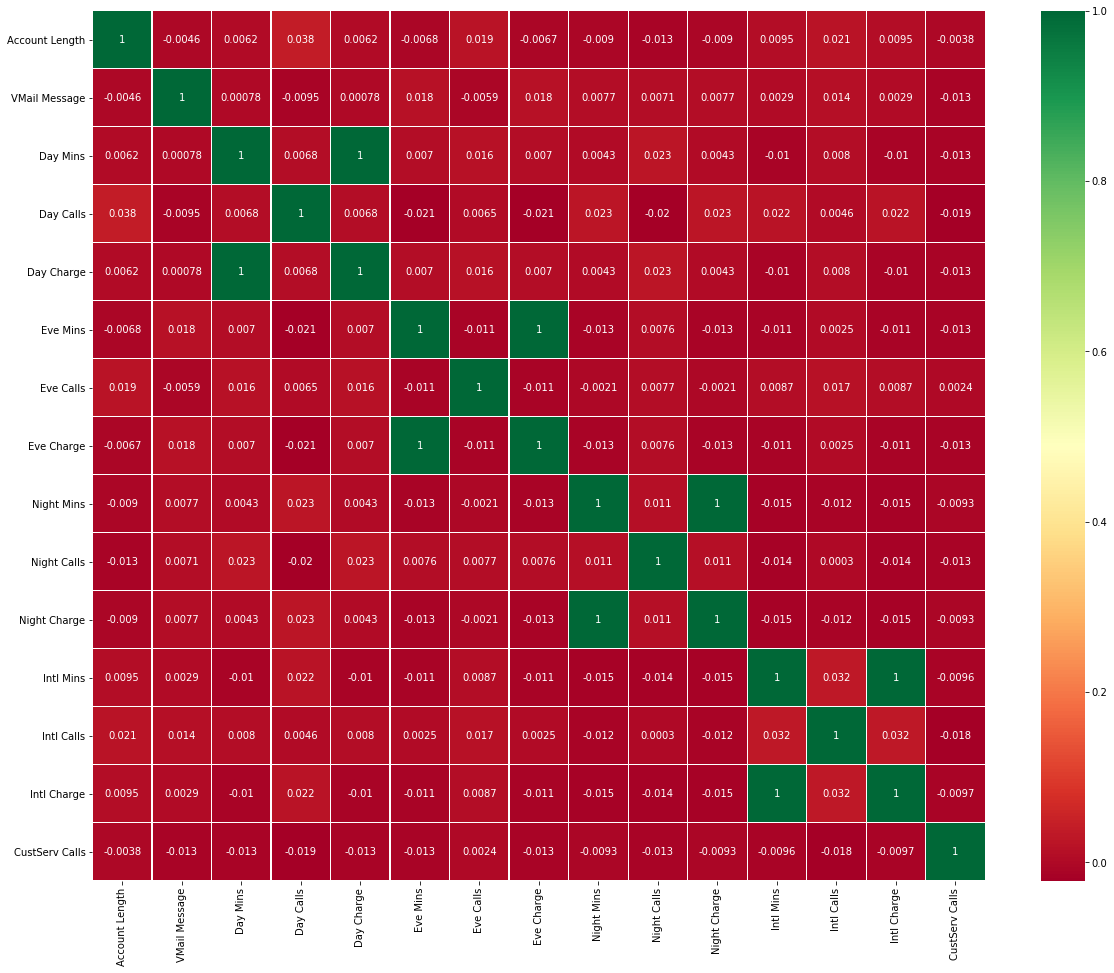

In [12]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show()

In [13]:
#Dropping fields that are correlated to other fields
data.drop(columns = ['Day Charge','Eve Charge','Night Charge','Intl Charge'],inplace=True)

### Missing data check
- No missing data found

In [14]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
Churn?,0,0.0
Day Mins,0,0.0
Account Length,0,0.0
Area Code,0,0.0
Phone,0,0.0
Int'l Plan,0,0.0
VMail Plan,0,0.0
VMail Message,0,0.0
Day Calls,0,0.0
CustServ Calls,0,0.0


### Analyze relationship between features, and target variable
Pair plots (Bi-variate scatter plots) can be used similar to correlation plots, to observe correlations and also compare patterns in the target variable


Here we plot the pair plots, with the target variable "Churn" in hue i.e. The Blue and Red points represent the two values of Churn - yes/no.<br>
The diagonal shows the distribution of the two target classes against each variable.

Parameters used:
1. hue: Variable in data to map plot aspects to different colors
2. palette: Set of colors for mapping the hue variable
3. size: factor by which the figure is resized
4. diag_kind: Kind of plot for the diagonal subplots (kde = kernel density estimate)
5. diag_kws: Dictionaries of keyword arguments (settings for diagonal plots)
6. plot_kws: Dictionaries of keyword arguments (settings for other plots)

Observations:
- No multi-collinearity can be observed between variables
- We see that the target variable is distributed in a <b>non-linear radial pattern</b> in the pair plots
- This indicates that non-linear and ensemble classifiers might perform better on this data than linear classifiers

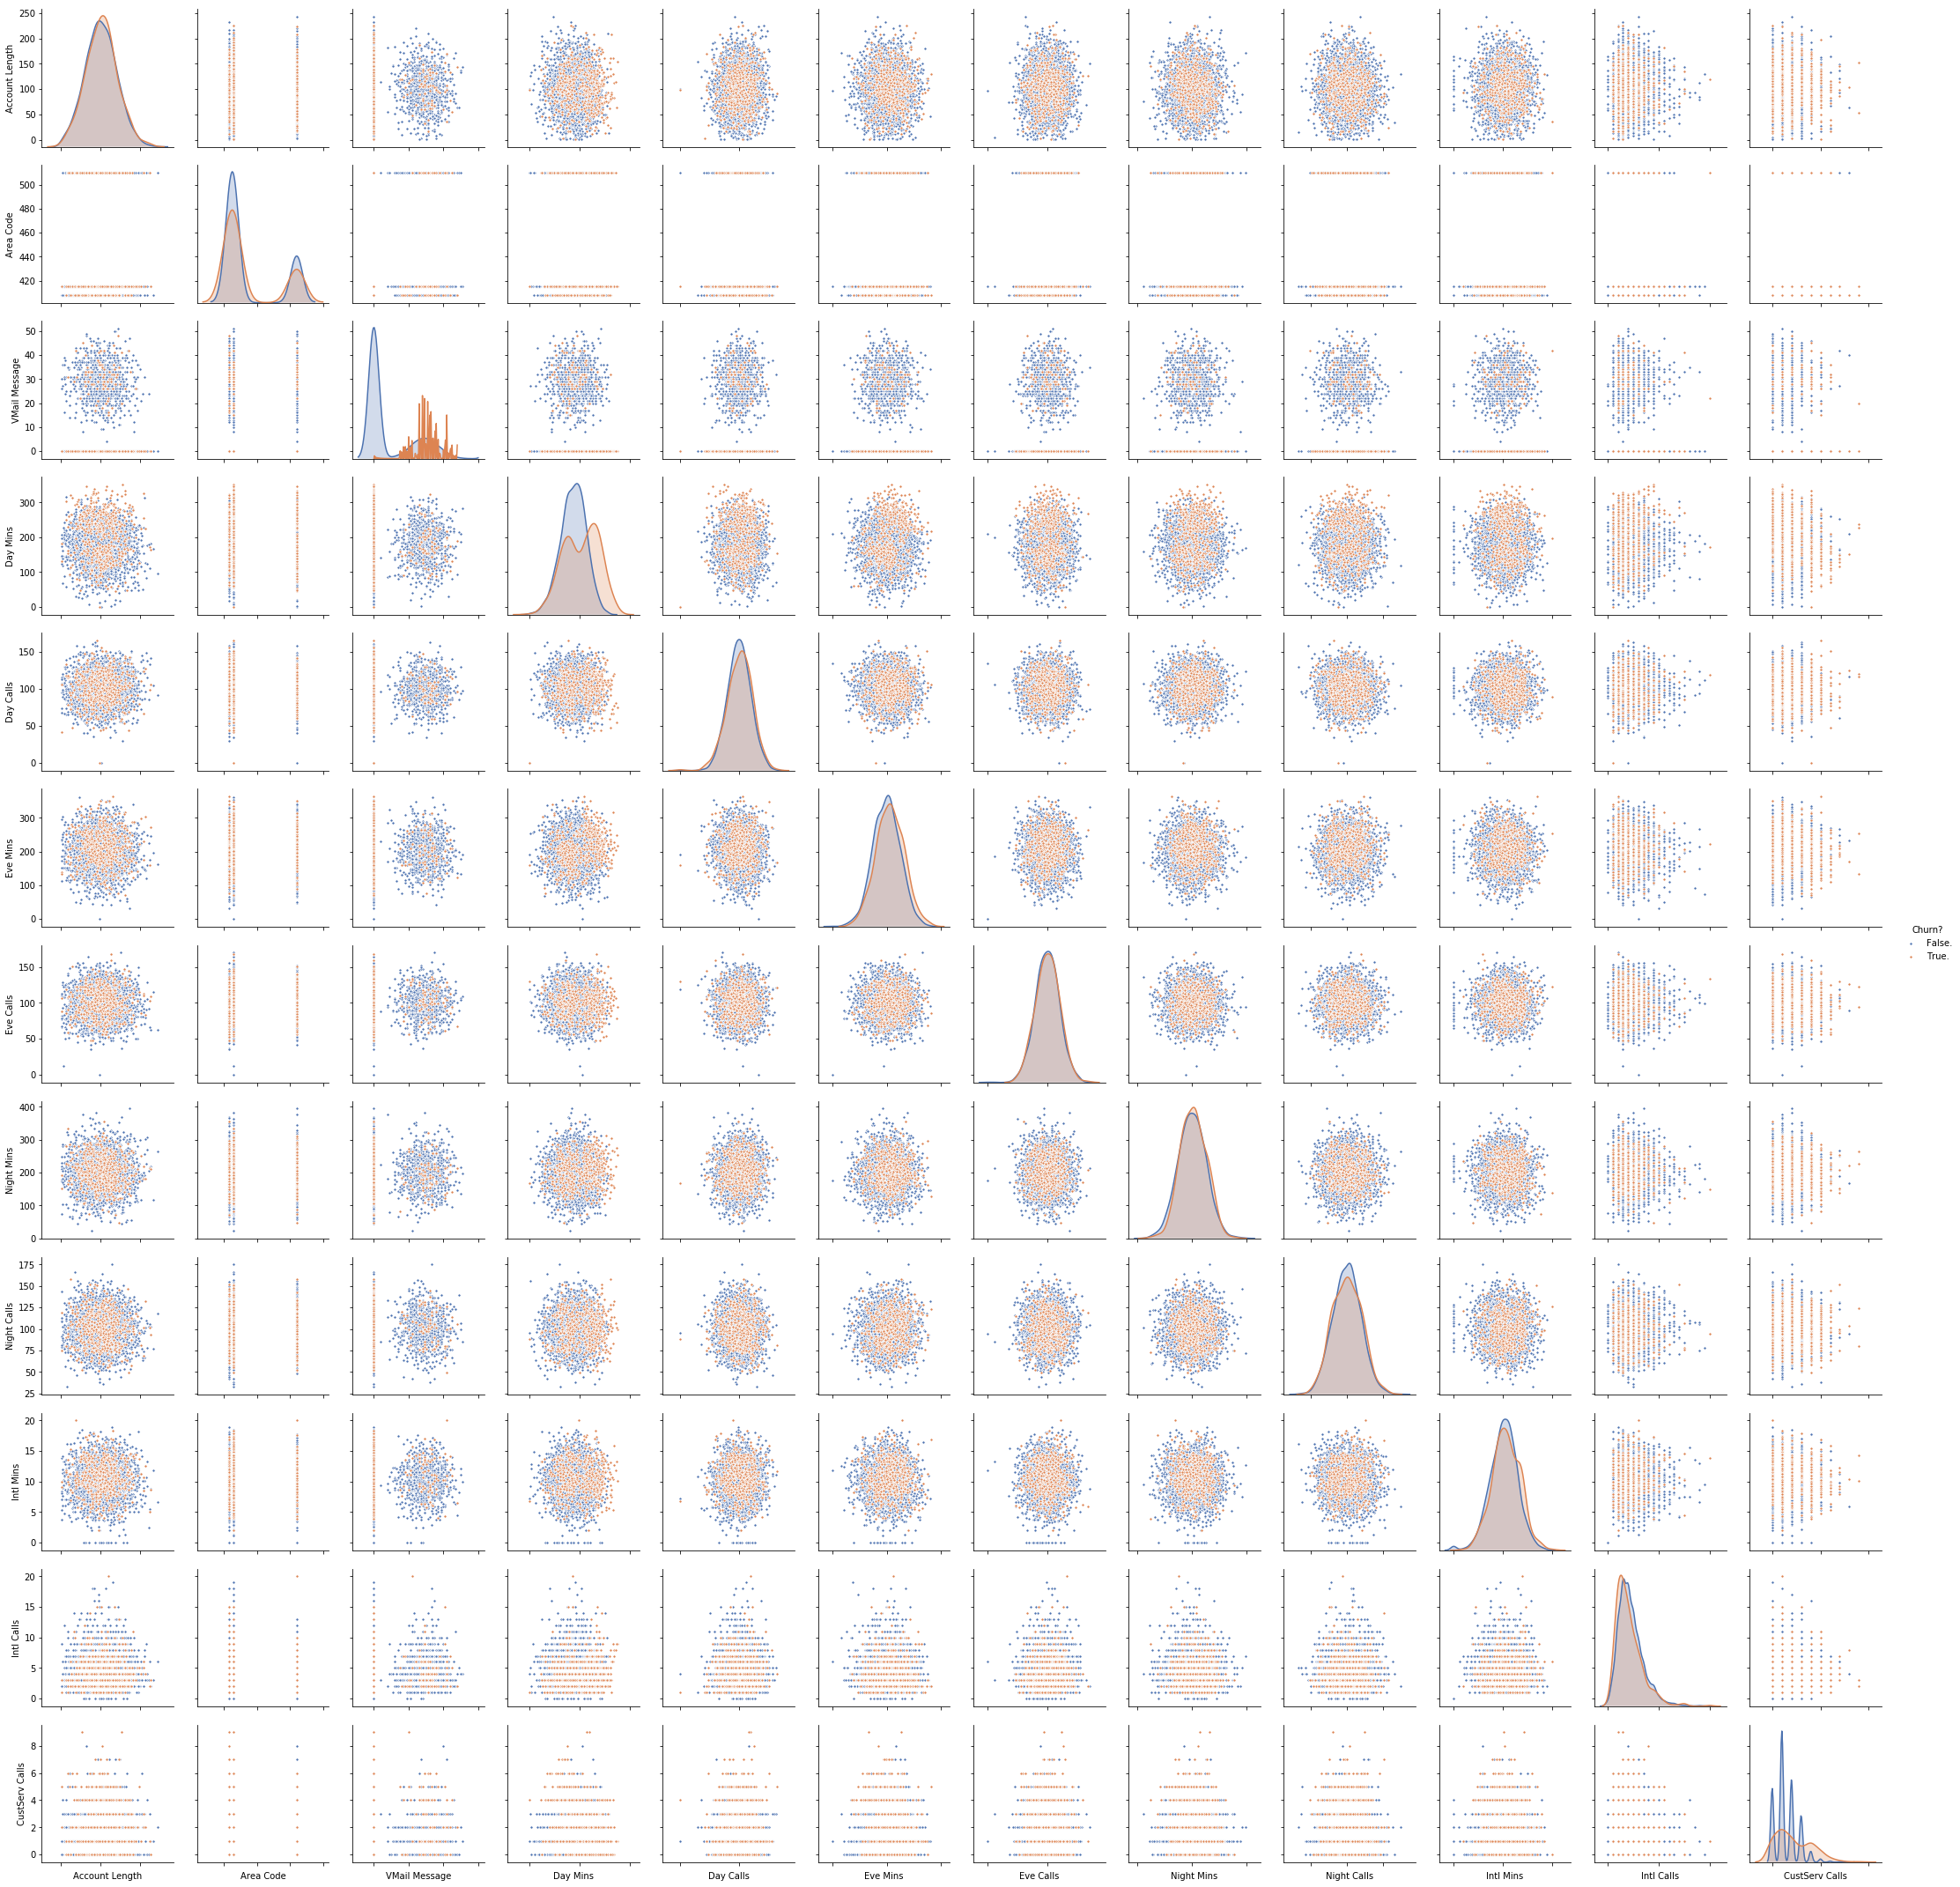

In [15]:
pp = sns.pairplot(data, hue = 'Churn?', palette = 'deep', size=2.5, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])
plt.show()

## Data Preperation

### Define Following:
* Independent features (X)
* Target feautres (y)
* Id features (ids)


In [16]:
X    = data.drop(target_variable + id_variable,axis=1)
y    = data[target_variable]
ids  = data[id_variable]

### Convert categorical variable into dummy/indicator variables
Since some Classifier algorithms do not accept categorical fields, they need to be transformed
There are two methods for transforming categorical fields: <br>

<b>1. Label encoding</b> - each unique category value is assigned an integer value<br>
<b>2. One Hot encoding</b> - the integer encoded variable is removed and a new binary variable is added for each unique integer value

The first one is not preferred since the classification algorithms tend to assume a natural ordering between categories, which may result in poor performance or unexpected results

#### One Hot encoding using get_dummies

In [17]:
X_with_dummy_features = pd.get_dummies(X,drop_first=True)
y_with_dummy_features = pd.get_dummies(y,drop_first=True)

* Next Steps for DS - Explore difference between Label encoder and get dummies

### Splitting into train and test datasets

A better way to test a model is to use a hold-out set which doesn't enter the training. This operation can be performed using scikit-learn's train/test split utility:
<cite>
<b>Stratified sampling</b> is a probability sampling technique; to divide the entire population into different subgroups or strata, then randomly selects the final subjects proportionally from the different strata.</cite>

In [18]:
xtrain, xtest, ytrain, ytest , id_train, id_test = train_test_split \
                (X_with_dummy_features, y_with_dummy_features,ids,test_size=0.5, \
                stratify=y_with_dummy_features,random_state=1000)
print ("No. of True Cases in training data set for" , ytrain.values.ravel().sum())
print ("No. of True Cases in testing data set for",ytest.values.ravel().sum())

print ("Ratio of True Cases in training data set: " , round(ytrain.values.ravel().sum()/len(ytrain.values.ravel()),2))
print ("Ratio of True Cases in testing data set: ", round(ytest.values.ravel().sum()/len(ytest.values.ravel()),2))

No. of True Cases in training data set for 241
No. of True Cases in testing data set for 242
Ratio of True Cases in training data set:  0.14
Ratio of True Cases in testing data set:  0.15


## Model training and evaluation of different classifiers

### 1. Logistic Regression

<cite>
<b>Logistic regression</b> is an easy to interpret and computationally inexpensive classification algorithm. It uses the natural logarithm function to find the relationship between the variables and uses test data to find the coefficients.</cite>
* Benefits - Easy to interpret
* Limitations - Performs poorly with non-linear relationships, suffers because of outliers

In [19]:
#initialize model performance comparison dataframe
eval_results_compare = pd.DataFrame()

In [20]:
model_name = 'Logistic Regression'
logreg = LogisticRegression()
trained_model_lr = logreg.fit(xtrain, ytrain.values.ravel())

In [26]:
print ("Trained model :: ", trained_model_lr)

Trained model ::  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [28]:
prob_test  = trained_model_lr.predict_proba(xtest)
prob_train = trained_model_lr.predict_proba(xtrain)

#Probability Threshold = 0.5 (default) 
pred_test  = trained_model_lr.predict(xtest)
pred_train = trained_model_lr.predict(xtrain)

<cite><b>AUC Score</b></cite> (Area under the Curve)
- Metric to calculate the overall performance of a classification model based on area under the ROC curve

In [30]:
#Calculate AUC
auc_score = roc_auc_score(ytest, prob_test[:,1])
print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                      % auc_score)



Model ROC-AUC score for validation sample: 0.800


<cite><b>Train and test Accuracy</b></cite>
 - Accuracy is the fraction of predictions correctly predicted by the classifier

In [31]:
#Calculate train and test accuracy
train_acc = accuracy_score(ytrain.values.ravel(), pred_train)
test_acc  = accuracy_score(ytest.values.ravel(), pred_test)
print ("\nTrain Accuracy :: ", train_acc)
print ("\nTest Accuracy :: ", test_acc)


Train Accuracy ::  0.8637454981992797

Test Accuracy ::  0.859628074385123


<cite><b>Confusion matrix</b></cite>
- A confusion matrix is a 2x2 contingency table that is used to describe the performance of a classification model on a set of test data for which the true values are known.


 Confusion matrix: 



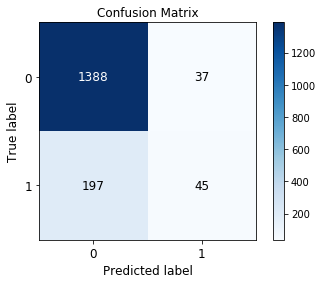

In [32]:
print ("\n Confusion matrix: \n")
skplt.metrics.plot_confusion_matrix(ytest.values.ravel(), pred_test, title="Confusion Matrix",
                text_fontsize='large')
plt.show()
# Colors https://matplotlib.org/examples/color/colormaps_reference.html

<cite><b>Precision, recall, F1-score</b></cite>

- <b>Recall</b>: Proportion of actual positives (TP + FN) that were identified correctly (TP) --> TP / (TP + FN)

- <b>Precision</b>: Proportion of positive identifications (TP + FP) that were actually correct (TP) --> TP / (TP + FP)

- <b>F1 score</b>: single metric that combines recall and precision using the harmonic mean
- To calculate the average, a macro <b>weighted average</b> is used, based on the number of instances for each label
- Weighted average gives a better average for an imbalanced dataset, but the impact of the less frequent class is muted
- The <b>precision - recall</b> curve, along with the ROC curve, can be used to select an <b>optimal threshold</b> cut-off, based on the business objective of the predictive classifier

In [34]:
#Calculate classification model evaluation metrics like precision, recall, f1 score
report = classification_report(ytest, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(ytest,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(ytest, pred_test))


 Classification report (weighted average across classes) ::
              precision    recall  f1-score   support

          0       0.88      0.97      0.92      1425
          1       0.55      0.19      0.28       242

avg / total       0.83      0.86      0.83      1667



#### Observation:
* We can see that the weighted average is skewed towards the majority class, thus we will use the precision, recall and f1-score of the positive (minor) class for further model evaluations
* Probability threshold used: 0.5 (default)

### Next Question : Identify optimal probabilty threshold ?
- From the plot, we observe that a threshold lower than 0.3 will be required for a high recall value

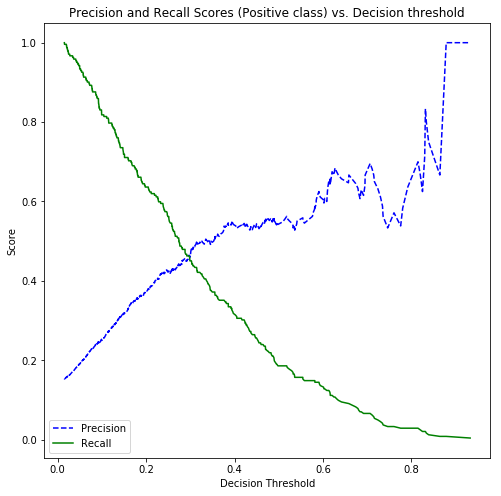

In [35]:
#Obtain the precision and recall for the corresponding variations in threshold
p, r, thresholds = precision_recall_curve(ytest, prob_test[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    """
   
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores (Positive class) vs. Decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p, r, thresholds)
plt.show()

Lift plot for validation Sample


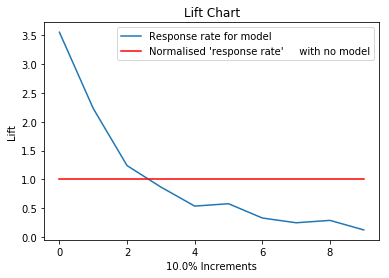

ROC curve for the validaton Sample


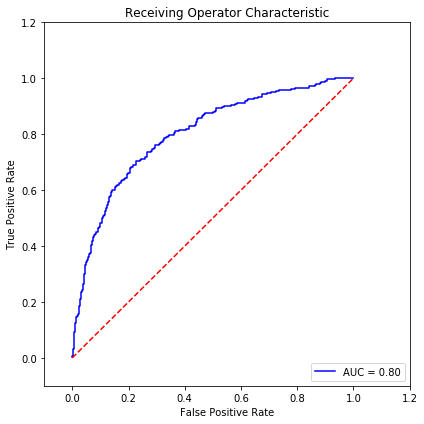

In [36]:
#Calculate key performance metrics for model validation
eval_result_LR = evaluate_model(model_name, trained_model_lr, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_LR)
eval_results_compare.reset_index(drop=True,inplace=True)

In [37]:
eval_results_compare

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.18595,0.54878,0.277778,0.33673,3.55372,2.2314


#### Final model evaluation summary: 
- Recall, Precision and F1 Score are calculated for Target = True (Churners), to get a picture of how the classifiers perform for the minority class

### 2. Naive Bayes

<cite>
Simple probabilistic classifier based on applying Bayes' theorem with strong (naive) independence assumptions between the features </cite>
* Benefits - SImple and fast, works well with small size of data
* Limitations - Fails estimating rare occurrences, Bad estimator – probabilities might not be reliable

In [38]:
model_name        = 'Gaussian Naive Bayes'
gnb               = GaussianNB()
trained_model_gnb = gnb.fit(xtrain, ytrain.values.ravel())

#### Model Performance Validation

Lift plot for validation Sample


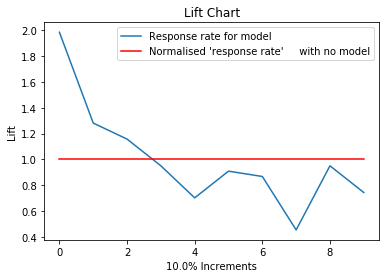

ROC curve for the validaton Sample


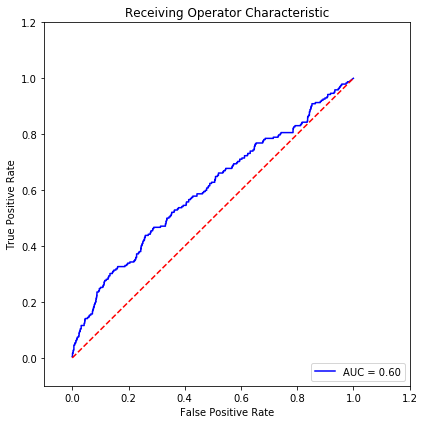

In [41]:
#Calculate key performance metrics for model validation
eval_result_GNB = evaluate_model(model_name, trained_model_gnb, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_GNB)

In [42]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099


#### Model Performance Observations:
- Naive Bayes performs better in terms of Recall but it is worse in Precision and Accuracy than Logistic Regression.

### 3. Decision Tree
<cite>
<b>Decision Tree</b> algorithm is used to create a training model which can use to predict class or value of target variables by learning decision rules inferred from prior data(training data).</cite>
* Benefits - Easy to understand and visualize, Handles both numeric and categorical data well
* Limitations - Overfitting is common, pruning becomes essential

In [43]:
model_name = 'Decision Tree'
dt=DecisionTreeClassifier()
trained_model_dt = dt.fit(xtrain,ytrain)

#### Visualizing the decision tree

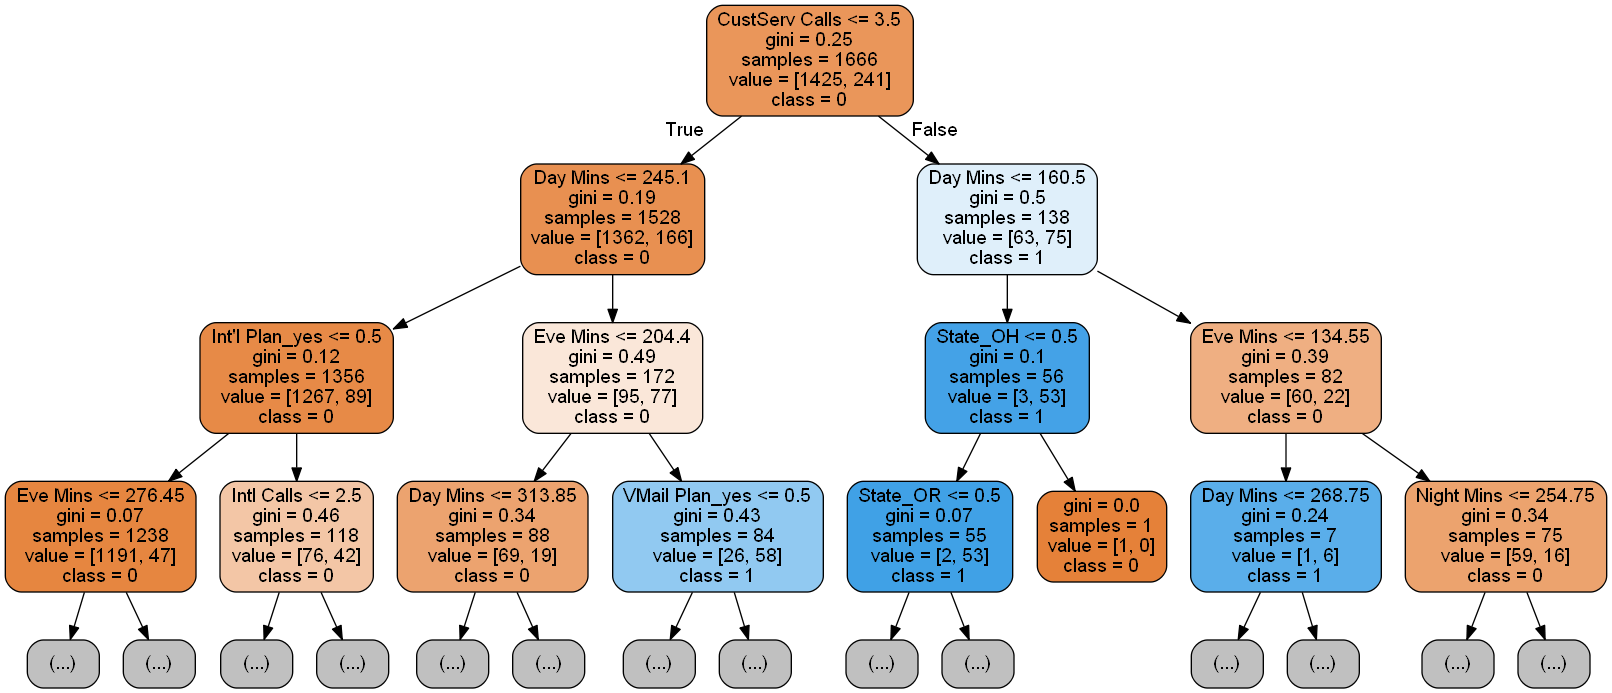

In [44]:
dot_data = StringIO()

export_graphviz(trained_model_dt, out_file=dot_data, 
                feature_names = xtrain.columns,
                max_depth = 3,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Model Performance Validation

Lift plot for validation Sample


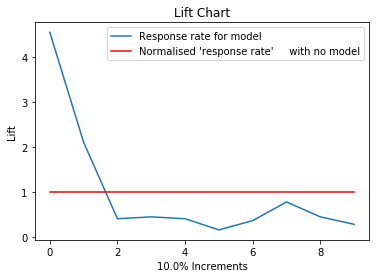

ROC curve for the validaton Sample


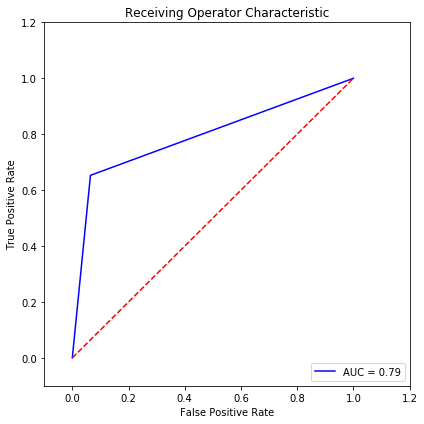

In [45]:
#Calculate key performance metrics for model validation
eval_result_DT = evaluate_model(model_name, trained_model_dt, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_DT)
eval_results_compare.reset_index(drop=True,inplace=True)

In [46]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744


#### Model Performance Observations:
- Decision tree performs better than other models overall with respect to Recall, Precision and Accuracy

### 4. Random Forest

<cite>
    <b>Random Forest</b> is a flexible, easy to use machine learning algorithm that produces, a great result most of the time. Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction</cite>

* Benefits - Reduces variances and avoids overfitting, robust and accurate
* Limitations - large number of trees may slow down perormance, less interpretability

In [47]:
# Create random forest classifier model to predict chrun
model_name = 'Random Forest'
clf = RandomForestClassifier()
trained_model_rf = clf.fit(xtrain, ytrain.values.ravel())

#### We can also save trained models to disk using pickle and load them anytime later

In [48]:
# save the model to disk
filename = '../models/baseline_randomforest_model.sav'
pickle.dump(trained_model_rf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
trained_model_rf = pickle.load(open(filename, 'rb'))

#### Model Performance Validation

Lift plot for validation Sample


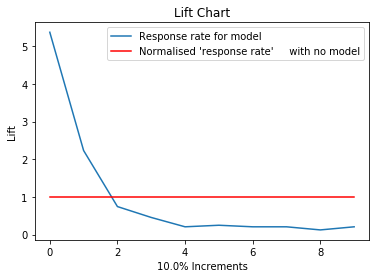

ROC curve for the validaton Sample


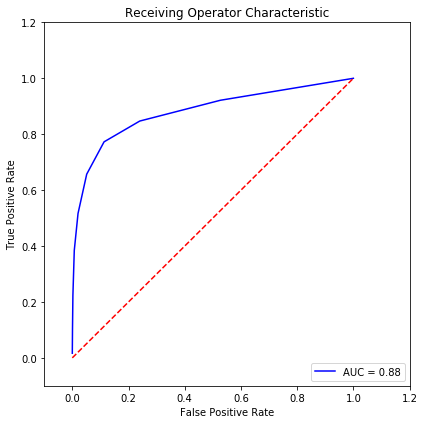

In [49]:
#Calculate key performance metrics for model validation
eval_result_RF = evaluate_model(model_name, trained_model_rf, xtrain, xtest, ytrain, ytest, verbose = False)

In [50]:
#Append model results to a comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_RF)

In [51]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314


#### Model Performance Observations:
- Random Forest has high performance in Accuracy and Precision, but not in Recall. Tuning is required
- We will try to tune the parameters and decision threshold for Random forest in the following section

### 5. Gradient Boosting Classifier
<cite>
    <b>Gradient boosting</b> is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. </cite>
    
* Benefits - Generally performs extremely well, Robust to outliers, scalable and smaller datasets
* Limitations - Harder to tune, training takes longer because of sequential ensembling

In [52]:
model_name = 'Gradient Boosting Classifier'
grb = GradientBoostingClassifier()
trained_model_grb = grb.fit(xtrain,ytrain.values.ravel())

#### Model Performance Validation

Lift plot for validation Sample


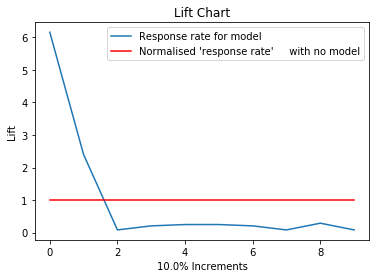

ROC curve for the validaton Sample


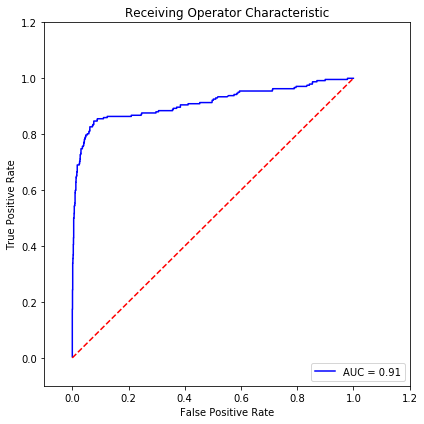

In [53]:
#Calculate key performance metrics for model validation
eval_result_GRB = evaluate_model(model_name, trained_model_grb, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_GRB)
eval_results_compare.reset_index(drop=True,inplace=True)

In [54]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314
5,Gradient Boosting Classifier,0.911425,0.935213,0.690083,0.835000,0.755656,0.193362,6.15702,2.39669


#### Model Performance Observations:
- Gradient Boosting Classifier has a high overall performance

### 6. XGBoost
<cite>
    <b>XGBoost</b> is an implementation of gradient boosted decision trees designed for speed and performance. It is a scalable and accurate implementation of gradient boosting machines and it has proven to push the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed </cite>
   
Parameters used:
- objective = 'binary:logistic': Outputs probability for two classes
- eval_metric = 'error': Evaluation metrics for validation data, error = (# wrong cases) / (# all cases)

* <b>Benefits</b>     - Fast, efficient, scalable and flexible
* <b>Limitations</b>  - Black box, low interpretability

In [55]:
model_name = 'XGBoost'
xgb = XGBClassifier(objective = 'binary:logistic', eval_metric="error")
trained_model_xgb = xgb.fit(xtrain,ytrain.values.ravel())

#### Model Performance Validation

Lift plot for validation Sample


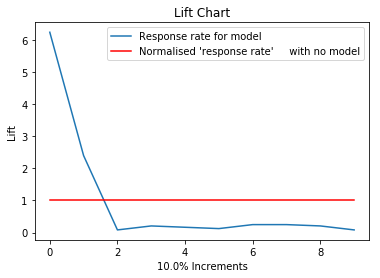

ROC curve for the validaton Sample


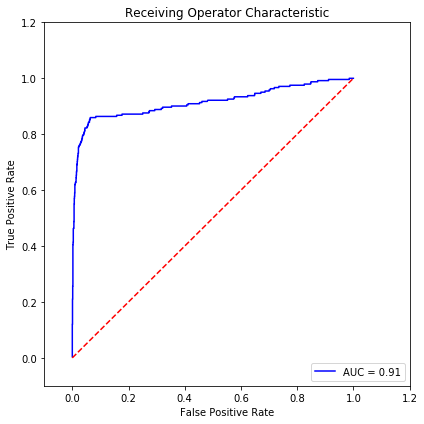

In [56]:
#Calculate key performance metrics for model validation
eval_result_XGB = evaluate_model(model_name, trained_model_xgb, xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_XGB)
eval_results_compare.reset_index(drop=True,inplace=True)

In [57]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314
5,Gradient Boosting Classifier,0.911425,0.935213,0.690083,0.835000,0.755656,0.193362,6.15702,2.39669
6,XGBoost,0.914434,0.938212,0.665289,0.879781,0.757647,0.191386,6.23967,2.39669


#### Model Performance Observations:
- XGBoost has similar performance to Gradient Boosting Classifier

## Hyperparameter tuning using GridSearchCV
- In this module, we will use <b>GridSearchCV</b> for tuning the parameters of one of the model algorithms, to achieve optimum performance

### Random Forest Hyper-parameter tuning using GridSearchCV
GridSearchCV takes a scoring parameter used to choose the best performing model.
The various metrics that can be used for scoring along with their usage scenarios:
 1. <b>accuracy</b> - Used when the objective is to maximize predictive accuracy of the model
 2. <b>average_precision</b> (area under the precision-recall curve) - Used when the objective is to minimize false positives
 3. <b>precision</b> - Used when the objective is to minimize false positives
 4. <b>recall</b> - Used when the objective is to correctly identify maximum positives, at the cost of false positives
 5. <b>f1</b> - Used when the objective is to gain an optimal blend between precision and recall
 6. <b>roc_auc</b> - Used when the objective is to maximize predictive power of the model

Note: <b>Accuracy Paradox</b> for Predictive Analytics states that Predictive Models with a given level of Accuracy may have greater Predictive Power than Models with higher Accuracy, expecially in the case of imbalanced classes. A model might be predicting the majority class with high accuracy resulting in a high accuracy score, but it performs poorly on the other class.

In this case, we use <b>recall</b> as the scoring parameter since the objective is to correctly predict as many churners as possible. We are not concerned about False positives since there is not much of a loss in wrongly predicting a Churner.

List of tuning parameters:
1. <b>max_features</b>: maximum number of features Random Forest is allowed to try in individual tree
2. <b>n_estimators</b>: number of trees you want to build before taking the maximum voting or averages of predictions
3. <b>max_depth</b>: max number of levels in each decision tree 
4. <b>min_samples_split</b>: min number of data points placed in a node before the node is split
5. <b>min_samples_leaf</b>: min number of data points allowed in a leaf node

#### Plot Validation Curve for "n_estimators" parameter of Random Forest with "Test Accuracy" as the scoring metric
- Validation curve visualizes the performance metric over a range of values for some hyperparameter
- Below, we observe how Test Accuracy varies with increase in number of estimators (trees)

In [ ]:
# Create range of values for parameter
param_range = np.arange(1, 1000, 8)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             xtrain, 
                                             ytrain, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3,
                                             scoring="accuracy", 
                                             n_jobs=4,
                                             verbose = 2)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("CV Accuracy")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### 7. Optimizing RF model with Gridsearch
#### Let's tune the <cite>max_depth</cite> and <cite>n_estimators</cite> parameters of Random Forest classifier and observe the improved performance

In [58]:
# Create the parameter grid based on the results of random search 
model_name = 'Random Forest - Hp tuned'
param_grid = {
    'max_depth': [50, 100, 150, 200, 250, 300],
    'n_estimators': [50, 100, 200, 300, 400, 500]
}

rf = RandomForestClassifier()
tuning_rf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'recall',
                          cv = 3, n_jobs = 4, verbose = 2)
tuning_rf.fit(xtrain, ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:   50.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [50, 100, 150, 200, 250, 300], 'n_estimators': [50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

#### Plot Validation Curve for the RF Hypertuning

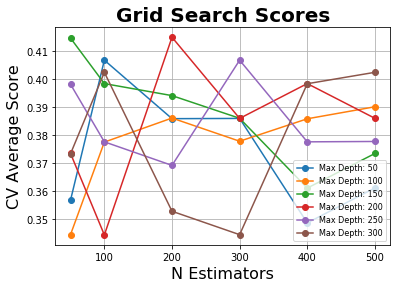

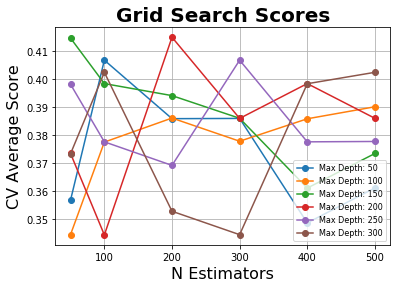

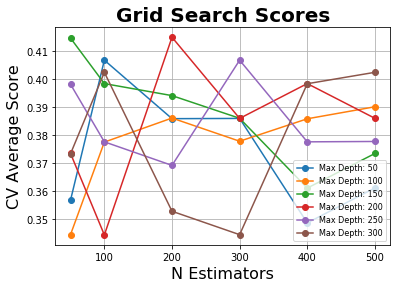

In [61]:
plot_grid_search(tuning_rf.cv_results_, param_grid['n_estimators'], param_grid['max_depth'], 'N Estimators', 'Max Depth')
plt.show()

#### Best estimator, tuned parameters and corresponding best score using GridSearchCV

In [62]:
print('Grid search results:\nBest parameters: {}, Best mean cross-validated score: {}'.format(tuning_rf.best_params_, tuning_rf.best_score_)) 

Grid search results:
Best parameters: {'max_depth': 200, 'n_estimators': 200}, Best mean cross-validated score: 0.414964596949891


Lift plot for validation Sample


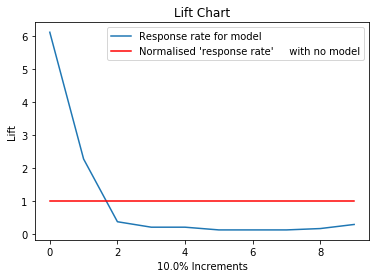

ROC curve for the validaton Sample


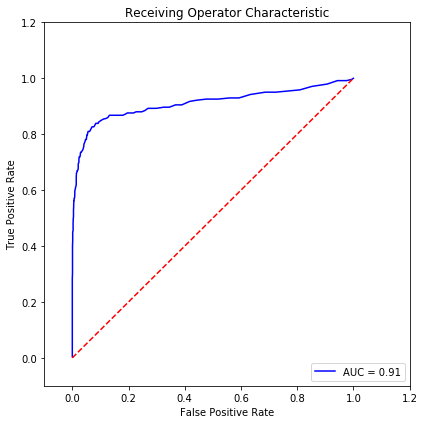

In [63]:
#Calculate key performance metrics for model validation
eval_result_GRB_tuned = evaluate_model(model_name, tuning_rf.best_estimator_ , xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_GRB_tuned)
eval_results_compare.reset_index(drop=True,inplace=True)

In [64]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314
5,Gradient Boosting Classifier,0.911425,0.935213,0.690083,0.835000,0.755656,0.193362,6.15702,2.39669
6,XGBoost,0.914434,0.938212,0.665289,0.879781,0.757647,0.191386,6.23967,2.39669
7,Random Forest - Hp tuned,0.910484,0.927415,0.524793,0.954887,0.677333,0.257591,6.1157,2.27273


#### Model Performance Observations:
- We observe that the tuned Random Forest performs worse that decision trees, in terms of Recall for the positive class
- Let's try to set the right decision threshold, to improve performance

#### 8. Optimizing RF model with Optimal Decision Threshold 

Get the predicted probabilities from the best Random Forest classifier

In [65]:
trained_model = tuning_rf.best_estimator_

prob_test = trained_model.predict_proba(xtest)
prob_train = trained_model.predict_proba(xtrain)

Distribution of predicted probabilities of Random Forest classifier
- We observe that the default 0.5 threshold might be missing out on the model's predictions due to the imbalanced data

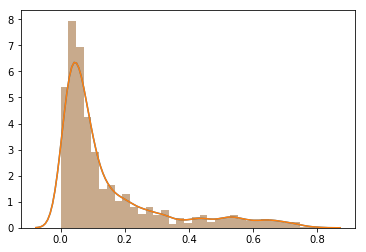

In [67]:
sns.distplot(prob_test[:,1])
plt.show()

Check Precision-Recall vs Decision Threshold Plot to set the optimal threshold
- Here we see that <b>threshold = 0.3</b> might be a good tradeoff between Recall and Precision

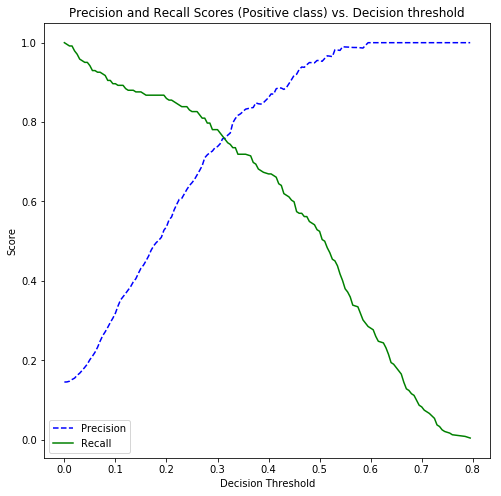

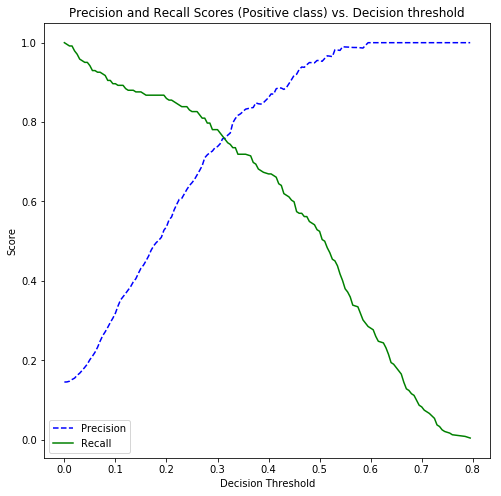

In [69]:
p, r, thresholds = precision_recall_curve(ytest, prob_test[:,1])
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.show()

#### Evaluate Random Forest tuned model using the new threshold (0.3)

In [70]:
threshold = 0.3
predicted = (prob_test [:,1] >= threshold).astype('int')
print("\n Classification report (weighted average across classes) ::\n", classification_report(ytest, predicted))


 Classification report (weighted average across classes) ::
              precision    recall  f1-score   support

          0       0.96      0.95      0.96      1425
          1       0.74      0.78      0.76       242

avg / total       0.93      0.93      0.93      1667



Lift plot for validation Sample


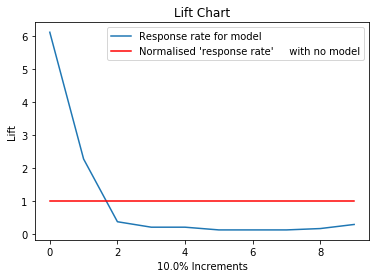

ROC curve for the validaton Sample


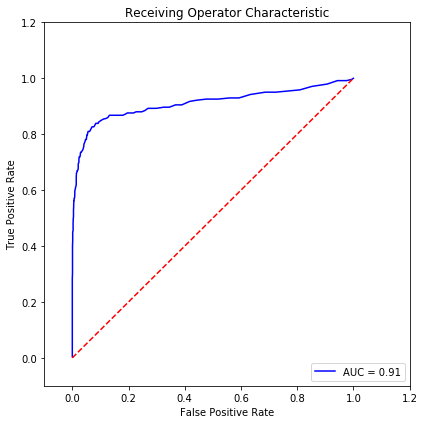

In [71]:
#Calculate key performance metrics for model validation
model_name = 'Random Forest - Hp, threshold tuned'
eval_result_GRB_tuned = evaluate_model(model_name, tuning_rf.best_estimator_ , xtrain, xtest, ytrain, ytest, verbose = False, threshold = 0.3)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_GRB_tuned)
eval_results_compare.reset_index(drop=True,inplace=True)

In [72]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314
5,Gradient Boosting Classifier,0.911425,0.935213,0.690083,0.835000,0.755656,0.193362,6.15702,2.39669
6,XGBoost,0.914434,0.938212,0.665289,0.879781,0.757647,0.191386,6.23967,2.39669
7,Random Forest - Hp tuned,0.910484,0.927415,0.524793,0.954887,0.677333,0.257591,6.1157,2.27273
8,"Random Forest - Hp, threshold tuned",0.910484,0.928014,0.780992,0.738281,0.759036,0.257591,6.1157,2.27273


## Ensembling

Ensembling is a good way to increase the accuracy or performance of a model. In simple words, it is the combination of various simple models to create a single powerful model

Ensembling can be done in ways like:

<b>1) Voting Classifier</b>
- It is the simplest way of combining predictions from various machine learning models. It gives an average prediction result based on the prediction of all the submodels

<b>2) Bagging</b>
- It works by applying similar classifiers on small partitions of the dataset and then taking the average of all the predictions. Due to the averaging, there is reduction in variance. Unlike Voting Classifier, Bagging makes use of similar classifiers

<b>3) Boosting</b>
- Boosting is an ensembling technique which uses sequential learning of classifiers. It is a step by step enhancement of a weak model, for example Gradient Boosting

#### Implementing a Soft Voting Ensemble Classifier
- Two types of voting methods:<br>
    <b>1. Hard Voting</b> - Uses predicted class labels for majority rule voting    
    <b>2. Soft Voting</b> - Predicts the class label based on the average of the predicted probabilities. This gives a more robust and nuanced resultant model

### 9. Ensemble model 
* Using the best performing models XGBoost and Gradient Boosting Classifier, creating a soft voting ensemble model:

In [73]:
model_name = 'Ensemble - XGB and Gradient Boosting'
xgb = XGBClassifier(objective = 'binary:logistic', eval_metric="error",
                       nthreads=2)
grb = GradientBoostingClassifier()

model = VotingClassifier(estimators=[('xgb', xgb), ('GBM', grb)], voting='soft')
trained_model_ensemble = model.fit(xtrain,ytrain)

Lift plot for validation Sample


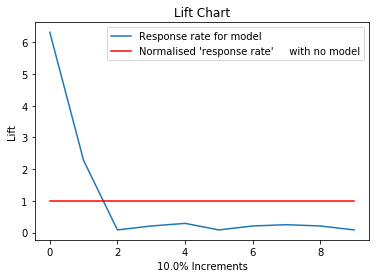

ROC curve for the validaton Sample


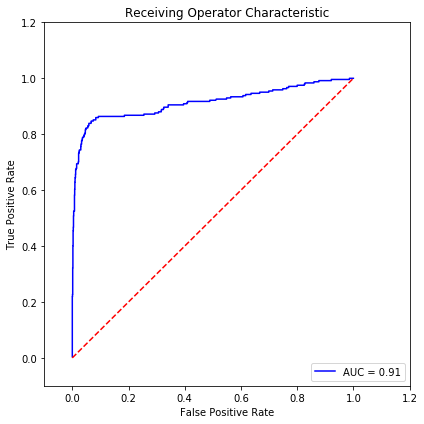

In [74]:
#Calculate key performance metrics for model validation
eval_result_ensemble = evaluate_model(model_name, trained_model_ensemble , xtrain, xtest, ytrain, ytest, verbose = False)

#Append key performance metrics to comparison dataframe
eval_results_compare = eval_results_compare.append(eval_result_ensemble)
eval_results_compare.reset_index(drop=True,inplace=True)

In [75]:
eval_results_compare.reset_index(drop = True)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Logistic Regression,0.800461,0.859628,0.185950,0.548780,0.277778,0.336730,3.55372,2.2314
1,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
2,Gaussian Naive Bayes,0.601006,0.480504,0.677686,0.172269,0.274707,6.168019,1.98347,1.28099
3,Decision Tree,0.794166,0.894421,0.652893,0.632000,0.642276,3.646610,4.54545,2.10744
4,Random Forest,0.881131,0.912418,0.516529,0.811688,0.631313,0.605890,5.3719,2.2314
5,Gradient Boosting Classifier,0.911425,0.935213,0.690083,0.835000,0.755656,0.193362,6.15702,2.39669
6,XGBoost,0.914434,0.938212,0.665289,0.879781,0.757647,0.191386,6.23967,2.39669
7,Random Forest - Hp tuned,0.910484,0.927415,0.524793,0.954887,0.677333,0.257591,6.1157,2.27273
8,"Random Forest - Hp, threshold tuned",0.910484,0.928014,0.780992,0.738281,0.759036,0.257591,6.1157,2.27273
9,Ensemble - XGB and Gradient Boosting,0.913546,0.941812,0.690083,0.883598,0.774942,0.189634,6.32231,2.27273


#### Model Performance Observations:
- The Ensemble model outperforms the models used to create it in terms of all performance metrics

## Detailed model comparison

#### Heatmap for performance metrics across models
- Darker shades indicate better performance
- We see that some Models with lower Test Accuracy have a high recall, i.e. they are correctly identifying more Churners, though at the expense of misclassifying many non-Churners as Churners (signified by the F1-Score)

In [76]:
cols = list(set(eval_results_compare.columns) - set(['Model']))
eval_results_compare[cols] = eval_results_compare[cols].astype(float)

num_cols = eval_results_compare.select_dtypes(float).columns
eval_results_compare[num_cols] = round(eval_results_compare[num_cols],4)

#Define colormap
cm = sns.light_palette("green", as_cmap=True)
eval_results_compare.sort_values(by='Test Accuracy',ascending=False).reset_index(drop=True).style.background_gradient(cmap = cm, high = 0.5, low = -0.5, axis = 0)

,Model,AUC,Test Accuracy,Recall_1,Precision_1,F1 Score_1,Log loss,Decile_1 Lift %,Decile_2 Lift %
0,Ensemble - XGB and Gradient Boosting,0.9135,0.9418,0.6901,0.8836,0.7749,0.1896,6.3223,2.2727
1,XGBoost,0.9144,0.9382,0.6653,0.8798,0.7576,0.1914,6.2397,2.3967
2,Gradient Boosting Classifier,0.9114,0.9352,0.6901,0.835,0.7557,0.1934,6.157,2.3967
3,"Random Forest - Hp, threshold tuned",0.9105,0.928,0.781,0.7383,0.759,0.2576,6.1157,2.2727
4,Random Forest - Hp tuned,0.9105,0.9274,0.5248,0.9549,0.6773,0.2576,6.1157,2.2727
5,Random Forest,0.8811,0.9124,0.5165,0.8117,0.6313,0.6059,5.3719,2.2314
6,Decision Tree,0.7942,0.8944,0.6529,0.632,0.6423,3.6466,4.5455,2.1074
7,Logistic Regression,0.8005,0.8596,0.186,0.5488,0.2778,0.3367,3.5537,2.2314
8,Gaussian Naive Bayes,0.601,0.4805,0.6777,0.1723,0.2747,6.168,1.9835,1.281
9,Gaussian Naive Bayes,0.601,0.4805,0.6777,0.1723,0.2747,6.168,1.9835,1.281


In [85]:
#Define all models
models = [
{
    'label': 'Logistic Regression',
    'model': trained_model_lr,
},
{
    'label': 'Gaussian Naive Bayes',
    'model': trained_model_gnb,
},
{
    'label': 'Decision Tree',
    'model': trained_model_dt,
},
{
    'label': 'Random Forest',
    'model': trained_model_rf,
},
{
    'label': 'Gradient Boosting Classifier',
    'model': trained_model_grb,
},
{
    'label': 'XGBoost',
    'model': trained_model_xgb,
},
{
    'label': 'Random Forest - tuned',
    'model': tuning_rf.best_estimator_,
}
,
{
    'label': 'Ensemble - XGB and Gradient Boosting',
    'model': trained_model_ensemble
}
]

#### ROC Curves comparison across all classifiers

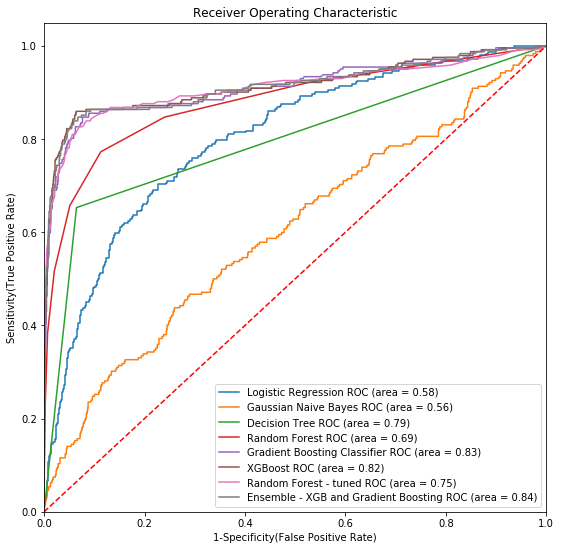

In [86]:
#Below for loop iterates through your models list and plots the ROC curves for each
plt.figure(figsize=(9,9))
for m in models:
    model = m['model'] # select the model
    y_pred=model.predict(xtrain) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(ytest, model.predict_proba(xtest)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(ytest,model.predict(xtest))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

#### Visual comparison of key performance metric across all classifiers
- The Random Forest model tuned for parameters and threshold outperforms the rest in terms of Recall for Positive Class (Churners)
- The Ensemble model performs the best in terms of Test accuracy (including both classes)

In [87]:
#Function to plot model vs performance metric bar chart
def plot_model_eval(data,metric):
    data = data.sort_values(by = metric)
    data[['Model', metric]].sort_values(by = metric).plot(kind='barh', alpha=0.55)
    plt.ylabel('Model', fontsize=15)
    plt.xlabel(metric, fontsize=15)
    plt.yticks(range(0,len(data.Model)), data.Model, fontsize=10)
    plt.show()

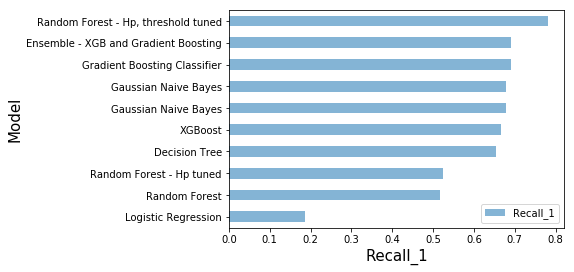

In [88]:
metric = 'Recall_1'
plot_model_eval(eval_results_compare,metric)

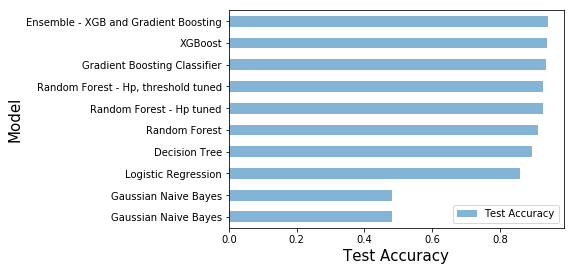

In [89]:
metric = 'Test Accuracy'
plot_model_eval(eval_results_compare,metric)

## Whiteboxing your Blackbox model

- Extracting Business relevant information from model outputs like the important variables affecting the target variable
- This helps enable business to choose between two models (which are close in performance) and implement the model where they feel more confidence

### Feature importance based on models
- Let's pick two similarly performing models, and extract the feature importance from them - Gradient Boosting Classifier and XGBoost

In [ ]:
var_imp_gbc = pd.DataFrame({'Feature':xtrain.columns,'Var Imp':trained_model_grb.feature_importances_}).sort_values(by='Var Imp',ascending = False).reset_index(drop=True)
print("Top 15 - Gradient Boosting Feature Importance")
var_imp_gbc.head(15).style.background_gradient(cmap = cm, high = 0.6, low = 0.3, axis = 0)

In [ ]:
var_imp_xgb = pd.DataFrame({'Feature':xtrain.columns,'Var Imp':trained_model_xgb.feature_importances_}).sort_values(by='Var Imp',ascending = False).reset_index(drop=True)
print("Top 15 - XGB Feature Importance")
var_imp_xgb.head(15).style.background_gradient(cmap = cm, high = 0.6, low = 0.3, axis = 0)

In [ ]:
print('Variable Importance - Combined')
var_imp_combined = var_imp_xgb.merge(var_imp_gbc, on = 'Feature', suffixes = ['_xgb','_gbc'])
var_imp_combined.head(15).style.background_gradient(cmap = cm, high = 0.6, low = 0.3, axis = 0)

#### Get significant variables based on variable importance

In [ ]:
number_imp_features = 10
imp_features = var_imp_combined.sort_values(by = 'Var Imp_xgb', ascending = False).Feature[:number_imp_features]

In [ ]:
print('List of significant variables:')
list(imp_features)

#### Calculate direction of each feature with respect to target
- Positive direction signifies that a True class (Churn = True) is likely to have higher magnitude of the variable (based on simple average)

In [ ]:
target = y_with_dummy_features.columns[0]
data_dummy_coded = X_with_dummy_features.join(y_with_dummy_features)
all_feature_vs_target = data_dummy_coded.groupby([target]).mean().T.reset_index().rename(columns={'index':'Feature',0:'Target False Avg',1:'Target True Avg'})
all_feature_vs_target['Direction vs Target'] = np.where(all_feature_vs_target['Target True Avg']>all_feature_vs_target['Target False Avg'],'Positive','Negative')
all_feature_vs_target.head(5)

#### Mean and direction of model significant variables with respect to target 

In [ ]:
result = var_imp_combined.merge(all_feature_vs_target, on = 'Feature')
result_imp = result[result.Feature.isin(list(imp_features))]
result_imp.style.background_gradient(cmap = cm, high = 0.6, low = 0.3, axis = 0, subset=pd.IndexSlice[:, ['Var Imp_xgb', 'Var Imp_gbc']])

#### Visualizing significant variables based on models
- We can see that Customer Service calls is not as important in Gradient Boosting Classifier as it is in XGBoost. 
- In case the business is aligned that Customer Service calls is an important variable, XGBoost could be preferred

In [ ]:
result_imp[['Feature', 'Var Imp_xgb', 'Var Imp_gbc']].sort_values(by = 'Var Imp_xgb').plot(kind='barh', alpha=0.5)
plt.ylabel('Model', fontsize=15)
plt.xlabel('Var Imp', fontsize=15)
plt.yticks(range(0,len(result_imp.Feature)), result_imp.Feature, fontsize=10)
plt.show()

### Local Interpretable Model-Agnostic Explanations (LIME)
Local interpretable model-agnostic explanations (LIME) allow us to explain individual predictions for "black box" models by creating local, interpretable, surrogate models

LIME can be used in the following ways:
1. Interpreting the significant variables involved in predictions of individual records
2. Choosing between competing models
3. Detect and improve untrustworthy models
4. Get insights into the models
    
LIME general approach:
1. For each prediction to explain, permute the observation n times.
2. Let the complex model predict the outcome of all permuted observations.
3. Calculate the distance from all permutations to the original observation.
4. Convert the distance to a similarity score.
5. Select m features best describing the complex model outcome from the permuted data.
6. Fit a simple model to the permuted data, explaining the complex model outcome with the m features from the permuted 
   data weighted by its similarity to the original observation.
7. Extract the feature weights from the simple model and use these as explanations for the complex models local behavior.

#### Extract wrong predictions of a classifier
- Using LIME, we will try to understand the incorrect predictions in classifiers, and the significant variables contributing to them

In [ ]:
model_pred = trained_model_lr.predict(xtest)

# Extract False Positives predictions
wrong_pred = (model_pred != ytest.values.ravel() ) & (model_pred == 1)

#Modify "i" to select row
i = 20

wrong = xtest.iloc[wrong_pred].iloc[i]
wrong_act = ytest.iloc[wrong_pred].iloc[i][0]

print('False Positive:\nPrediction: {}'.format(model_pred[wrong_pred][i]))
print('Actual Value: {}'.format(wrong_act))

#### Build Logistic Regression LIME explainer

In [ ]:

# Create a lime explainer object
explainer_lr = lime.lime_tabular.LimeTabularExplainer(training_data = xtrain.values, 
                                                   mode = 'classification',
                                                   training_labels = ytest.values.ravel(),
                                                   feature_names = xtrain.columns)


# Explanation for wrong prediction
exp_lr = explainer_lr.explain_instance(data_row = np.ravel(wrong), 
                                 predict_fn = trained_model_lr.predict_proba)

#### Build Random Forest - tuned LIME explainer

In [ ]:

# Create a lime explainer object
explainer_gbm = lime.lime_tabular.LimeTabularExplainer(training_data = xtrain.values, 
                                                   mode = 'classification',
                                                   training_labels = ytest.values.ravel(),
                                                   feature_names = xtrain.columns)


# Explanation for wrong prediction
exp_gbm = explainer_gbm.explain_instance(data_row = np.ravel(wrong), 
                                 predict_fn = trained_model_grb.predict_proba)

#### Comparison of LIME explanations for Logistic Regression and GBM for a False Postive
- The graph shows weighted features of a linear model, which approximates the behaviour of the classifier in the vicinity of the test example. 
- Example: If we remove 'Int'l Plan_yes' from the training data, the prediction should move towards the opposite class according to the weight calculated for 'Int'l Plan_yes'
- It can be observed that the two classifiers have varying impact from features on predictions. The right model can be picked based on business sense

LIME Explainer for Logistic Regression

In [ ]:
exp_lr.show_in_notebook()

LIME Explainer for GBM

In [ ]:
exp_gbm.show_in_notebook()

## Next steps for futher improving performance of Classifier solution

1. Extensive Pre-processing and Feature Engineering 
2. Tuning XGBoost, Gradient Boosting Classifier and the Ensemble model for optimal parameters and decision threshold
2. Trying a Neural Network Classifier
5. Model Stacking (Meta Ensembling): It is used to combine information from multiple predictive models to generate a new model. Stacking is most effective when the base models are significantly different. The procedure is as follows:
    - Split the training set into two disjoint sets.
    - Train several base learners on the first part.
    - Test the base learners on the second part.
    - Using the predictions from 3) as the inputs, and the correct responses as the outputs, train a higher level learner.

## Support Functions
1. lift_plot_model: Function to plot Lift Chart
2. plot_roc: Function to plot ROC Chart
3. evaluate_model: Function to calculate and return key model performance metrics and return them in a dataframe
4. plot_grid_search: Function to plot the validation curve for the GridSearchCV paramter tuning

In [ ]:

def lift_plot_model(ytest, yprob):
    '''
    Objective: Function to plot Lift Chart
    Argument : Actual Take up rate(1/0), predicted probabilities
    Returns  : Lift chart, Lift table
    Output   : Lift Chart

    '''

    n_bins = 10

    actual_ser = pd.Series(ytest).rename('actuals').reset_index()
    proba_ser = pd.Series(yprob).rename('probabilities').reset_index()

    # Join table and drop indicies
    lift_table = pd.concat([actual_ser, proba_ser], axis=1).fillna(0)
    #lift_table.drop('index', inplace=True)
    actual_col = 'actuals'

    probability_col = 'probabilities'
    
    lift_table.sort_values(by=probability_col, ascending=False, inplace=True)

    rows = []

    # Split the data into the number of bins desired.
    for group in np.array_split(lift_table, n_bins):
        score = group[(group[actual_col] == 1)][actual_col].sum()

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCompleted'] = lift['NumCases'].cumsum() - lift['NumCases']

    lift['PercentCorrect'] = lift['NumCorrectPredictions'].cumsum() / \
    lift['NumCorrectPredictions'].sum() * 100

    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    #lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
    #    lambda x: (x*1.0 / lift['NumCorrectPredictions'].sum()) * 100)

    #Lift Chart
    lift['LiftLine'] = 1
    lift['Lift'] = lift['NumCorrectPredictions'] / lift['AvgCase']

    plt.plot(lift['Lift'], label= 'Response rate for model');

    plt.plot(lift['LiftLine'], 'r-', label='Normalised \'response rate\' \
    with no model');

    plt.xlabel(str(100/len(lift)) + '% Increments');
    plt.ylabel('Lift');
    plt.legend();
    plt.title("Lift Chart");
    plt.show();
    return lift
    #plt.gcf().clear()



In [ ]:

def plot_roc(ytest_roc,yprob_roc):
        '''
        Objective: Function to plot ROC Graph
        Argument : ytest: Actual Take up rate(1/0), yprob: predcicted probabilities
        Returns  : ROC Plot
        Output   : ROC Plot

        '''
        fig = plt.figure(1, figsize=(6, 6));

        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(ytest_roc, yprob_roc)

        roc_auc = auc(false_positive_rate, true_positive_rate)

        plt.title("Receiving Operator Characteristic");

        plt.plot(false_positive_rate, true_positive_rate, 'b', \
        label='AUC = %0.2f' % roc_auc);

        plt.legend(loc='lower right');
        plt.plot([0,1], [0,1], 'r--');
        plt.xlim([-0.1, 1.2]);
        plt.ylim([-0.1, 1.2]);
        plt.ylabel("True Positive Rate");
        plt.xlabel("False Positive Rate");
        plt.tight_layout();

        nfig = plt.figure(2, figsize=(6, 6));
        plt.show();
        #plt.gcf().clear()



In [ ]:
def evaluate_model(model_name, trained_model, xtrain, xtest, ytrain, ytest, verbose = False, threshold = 0.5):
    '''
        Objective: Function to calculate and return key model performance metrics
        Arguments: 7 arguments
                    1) model_name: Name of the model
                    2) trained_model: Trained model
                    3) xtrain: Training data set for features
                    4) xtest: testing dataset for features
                    5) ytrain: Training data set for target
                    6) ytest: testing dataset for target
                    7) verbose: print key performance metrics if True (default False)
                    8) threshold: Decision threshold used to classify the predicted probabilities
        Returns  : pd.DataFrame containing all key performance metrics
        Output   : pd.DataFrame containing all key performance metrics, ROC plot, Lift plot

    '''
    #Predict using trained model for training and test datasets (with and without probabilities) 
    prob_test = trained_model.predict_proba(xtest)
    prob_train = trained_model.predict_proba(xtrain)
    pred_test = (prob_test [:,1] >= threshold).astype('int')
    pred_train = (prob_train [:,1] >= threshold).astype('int')
    
    #Calculate AUC
    auc_score = roc_auc_score(ytest, prob_test[:,1])
    
    #Calculate train and test accuracy
    train_acc = accuracy_score(ytrain.values.ravel(), pred_train)
    test_acc = accuracy_score(ytest.values.ravel(), pred_test)
   
    #Calculate log loss value
    log_loss_value = log_loss(ytest, prob_test[:,1],eps=1e-15, normalize=True)
    
    #Generate confusion matrix
    conf_matrix = confusion_matrix(ytest.values.ravel(), pred_test)

    #Calculate classification model evaluation metrics like precision, recall, f1 score
    report = classification_report(ytest, pred_test)
    precision,recall,fscore,support=precision_recall_fscore_support(ytest,pred_test)
    
    
    print ("Lift plot for validation Sample")
    lift_table = lift_plot_model(ytest.values.ravel(), prob_test[:,1])

    print ("ROC curve for the validaton Sample")
    plot_roc(ytest.values.ravel(), prob_test[:,1])
    
    #Collate all key performance metrics into a dataframe
    model_evaluation_metrics = pd.DataFrame({'Model': [model_name], 'AUC': [auc_score], 'Test Accuracy': [test_acc]
              , 'Recall_1': [recall[1]], 'Precision_1': [precision[1]], 'F1 Score_1': [fscore[1]]                           
              , 'Log loss': [log_loss_value]})
    model_evaluation_metrics.columns
    model_evaluation_metrics = model_evaluation_metrics[['Model', 'AUC', 'Test Accuracy',
                                                    'Recall_1', 'Precision_1', 'F1 Score_1','Log loss']]

    #Get lifts in top n deciles, where n is defined below
    n=2
    lift_table.reset_index(inplace = True)
    lift_table['index'] = lift_table['index'] + 1
    lift_table['Decile'] = lift_table['index'].apply(lambda x: 'Decile_' + str(x) + ' Lift %')
    top_decile_lifts = lift_table[0:n][['Decile','Lift']].T
    top_decile_lifts.columns = top_decile_lifts.iloc[0]
    top_decile_lifts = top_decile_lifts.reindex(top_decile_lifts.index.drop('Decile'))
    top_decile_lifts.reset_index(drop=True,inplace=True)
    
    #Add lift values for top deciles to the model key performance metrics
    model_evaluation_metrics = pd.concat([model_evaluation_metrics,top_decile_lifts],axis=1)
    
    #Print key performance metrics if verbose = True is passed as an argument
    if verbose == True:
        print ("Trained model :: ", trained_model)
        print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                          % auc_score)
        print ("\n\nTrain Accuracy :: ", train_acc)
        print ("\n\nTest Accuracy :: ", test_acc)
        print ("\n\nLog Loss Without for validation sample:", \
                        log_loss_value)
        
        print ("\n\n Confusion matrix \n")
        skplt.metrics.plot_confusion_matrix(ytest.values.ravel(), pred_test, title="Confusion Matrix",
            figsize=(4,4),text_fontsize='large')
        plt.show()
        
        print("\n\n Classification report (weighted average across classes) ::\n", classification_report(ytest, pred_test))

    return model_evaluation_metrics

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    '''
        Objective: To plot Validation Curve for GridSearchCV parameter tuning results 
        Arguments: 5 arguments
                    1) cv_results: Cross validation results from tuning
                    2) grid_param_1: List of parameter 1 values used for tuning
                    3) grid_param_2: List of parameter 2 values used for tuning
                    4) name_param_1: Parameter 1 name
                    5) name_param_2: Parameter 2 name
        Output   : Validation Curve plot with both parameters and CV results

    '''
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="lower right", fontsize=8)
    ax.grid('on')